<a href="https://colab.research.google.com/github/VictorPontual/ResNet_ImageClassifier/blob/main/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import pandas as pd
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

In [ ]:
!unzip -n /content/drive/MyDrive/Colab_Notebooks/Nonsegmented.zip -d ./plant-seedlings-classification

O código define geradores de dados usando ImageDataGenerator para realizar aumento de dados (data augmentation) e pré-processamento de imagens armazenadas em um diretório. Ele separa os dados em conjuntos de treinamento e validação (80/20), aplicando transformações como rotação, deslocamento, cisalhamento, zoom e flips para melhorar a generalização do modelo.

In [ ]:
def define_generators():
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=360,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.5,
        vertical_flip=True,
        horizontal_flip=True,
        validation_split=0.2, # Separar 20% dos dados para validação
    )



    train_generator = train_datagen.flow_from_directory(
        directory='./plant-seedlings-classification/Nonsegmented', # Caminho para a pasta principal
        target_size=(width, height),
        batch_size=batch_size,
        color_mode='rgb',
        class_mode="categorical",
        subset='training', # Usar os dados de treinamento
    )

    validation_generator = train_datagen.flow_from_directory(
        directory='./plant-seedlings-classification/Nonsegmented', # Caminho para a pasta principal
        target_size=(width, height),
        batch_size=batch_size,
        color_mode='rgb',
        class_mode="categorical",
        subset='validation', # Usar os dados de validação
    )

    return train_generator, validation_generator

O código define três callbacks para monitorar e ajustar o treinamento do modelo de forma eficiente:

1. **`ModelCheckpoint`**: Salva o modelo no arquivo `model.keras` apenas quando há uma melhora na métrica de validação (`val_accuracy`), garantindo que o melhor modelo seja armazenado.

2. **`EarlyStopping`**: Interrompe o treinamento antecipadamente se a perda de validação (`val_loss`) não melhorar por 10 épocas consecutivas, evitando sobreajuste e economizando tempo.

3. **`ReduceLROnPlateau`**: Reduz a taxa de aprendizado em um fator de 0.5 se a perda de validação (`val_loss`) não melhorar por 3 épocas, ajudando na convergência em estágios finais.

Esses callbacks são retornados como uma lista para serem usados durante o treinamento do modelo.

In [ ]:
def define_callbacks():
    save_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath='model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        verbose=1
    )
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6
    )

    return [save_callback, early_stopping, lr_scheduler]

O código define hiperparâmetros e configurações básicas para o treinamento de um modelo de classificação de imagens:

1. **`nb_epoch`**: Define o número total de épocas de treinamento (40).

2. **`batch_size`**: Configura o tamanho do lote (16 imagens por batch).

3. **`width` e `height`**: Especificam a dimensão das imagens (299x299 pixels) para redimensionamento. tamanho escolhido para dar uma maior resolução aos detalhes das imagens, algo de extrema importância no dataset avaliado.

4. **`species_list`**: Lista as classes do dataset, representando diferentes espécies de plantas que o modelo será treinado para classificar.

Essas definições configuram o ambiente para treinamento do modelo com um dataset de 12 classes.

In [1]:
nb_epoch     = 40
batch_size   = 16
width        = 299
height       = 299
species_list = ["Black-grass", "Charlock", "Cleavers", "Common Chickweed", "Common wheat", "Fat Hen",
                "Loose Silky-bent", "Maize", "Scentless Mayweed", "Shepherds Purse", "Small-flowered Cranesbill",
                "Sugar beet"]

O código implementa um **bloco residual** para redes ResNet, permitindo aprendizado eficiente em redes profundas ao usar uma **conexão de atalho** (shortcut). O bloco realiza o seguinte:

1. **Entrada principal**:
   - Aplica duas camadas convolucionais 3x3 com Batch Normalization e ativação ReLU na primeira convolução.
   - A segunda convolução não usa ativação imediatamente para permitir a soma residual.

2. **Atalho (shortcut)**:
   - Normalmente, copia a entrada diretamente.
   - Se `downsample=True`, ajusta o atalho usando uma convolução 1x1 com Batch Normalization para alinhar dimensões (espaciais e de canais) com a saída principal.

3. **Conexão residual**:
   - Soma o tensor do atalho (`shortcut`) com a saída das convoluções.
   - Aplica uma ativação ReLU na soma para obter a saída final do bloco.

Esse design melhora a propagação de gradientes e facilita o aprendizado em redes muito profundas.

In [ ]:
def residual_block(input_tensor, filters, stride=1, downsample=False):
    """
    Define um bloco residual.
    Args:
        input_tensor: tensor de entrada.
        filters: número de filtros para convoluções.
        stride: stride das convoluções.
        downsample: se True, aplica downsampling.
    """
    shortcut = input_tensor

    # Primeira camada
    x = keras.layers.Conv2D(filters, kernel_size=(3, 3), strides=stride, padding="same")(input_tensor)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)

    # Segunda camada
    x = keras.layers.Conv2D(filters, kernel_size=(3, 3), strides=1, padding="same")(x)
    x = keras.layers.BatchNormalization()(x)

    # Ajustar o atalho (shortcut) para corresponder as dimensões
    if downsample:
        shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), strides=stride)(input_tensor)
        shortcut = keras.layers.BatchNormalization()(shortcut)

    # Somar o atalho com a saída do bloco
    x = keras.layers.add([x, shortcut])
    x = keras.layers.ReLU()(x)

    return x

O código define uma função para construir uma rede neural convolucional do tipo **ResNet** personalizada, baseada em blocos residuais. O modelo é projetado para realizar tarefas de **classificação de imagens**.

A função permite especificar o formato das imagens de entrada, o número de classes para a saída e a quantidade de blocos residuais em cada estágio da rede. A arquitetura é composta por uma série de camadas convolucionais, seguidas de normalização e ativação, além de camadas de pooling para redução de dimensionalidade.

A rede é dividida em estágios, sendo que em cada estágio são aplicados blocos residuais que, por sua vez, ajudam a preservar informações importantes e a mitigar problemas como o desaparecimento do gradiente, comuns em redes profundas. Durante o processo, o número de filtros é duplicado a cada novo estágio, aumentando a capacidade de representação do modelo.

No final, o modelo realiza um **global average pooling** para reduzir a dimensionalidade das características extraídas e, em seguida, aplica uma camada densa com ativação softmax para a classificação das imagens nas classes fornecidas. O modelo é então retornado, pronto para treinamento e avaliação.

In [ ]:
def build_resnet(input_shape, num_classes, num_blocks=[2, 2, 2, 2]):
    """
    Constrói uma ResNet personalizada.
    Args:
        input_shape: shape das imagens de entrada (altura, largura, canais).
        num_classes: número de classes para a classificação.
        num_blocks: lista indicando o número de blocos em cada estágio.
    """
    inputs = keras.layers.Input(shape=input_shape)
    x = keras.layers.Conv2D(64, kernel_size=(7, 7), strides=2, padding="same")(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    x = keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding="same")(x)

    # Estágios da ResNet
    filters = 64
    for i, blocks in enumerate(num_blocks):
        for j in range(blocks):
            if j == 0 and i != 0:  # Downsampling para o primeiro bloco de cada estágio (exceto o primeiro estágio)
                x = residual_block(x, filters, stride=2, downsample=True)
            else:
                x = residual_block(x, filters)
        filters *= 2  # Dobrar os filtros a cada estágio

    # Camadas finais
    x = keras.layers.GlobalAveragePooling2D()(x)
    outputs = keras.layers.Dense(num_classes, activation="softmax")(x)

    # Criar o modelo
    model = keras.models.Model(inputs, outputs)
    return model

In [ ]:
# Gerar os dados
train_generator, validation_generator = define_generators()

# Construir o modelo (Ex.: ResNet)
model = build_resnet(input_shape=(width, height, 3), num_classes=len(species_list))

Found 4440 images belonging to 12 classes.
Found 1104 images belonging to 12 classes.


In [ ]:
# visualizar o formato dos dados
print(len(train_generator))
print(len(validation_generator))

278
69


In [ ]:
# Obter os callbacks
callbacks = define_callbacks()

# Compilar o modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Treinar o modelo
history = model.fit(
    train_generator,
    epochs=nb_epoch,
    validation_data=validation_generator,
    callbacks=callbacks
)


Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 513ms/step - accuracy: 0.3367 - loss: 2.1831
Epoch 1: val_accuracy improved from -inf to 0.19656, saving model to model.keras
278/278 ━━━━━━━━━━━━━━━━━━━━ 215s 668ms/step - accuracy: 0.3369 - loss: 2.1817 - val_accuracy: 0.1966 - val_loss: 6.5318 - learning_rate: 0.0010
Epoch 2/40
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.4924 - loss: 1.5292
Epoch 2: val_accuracy improved from 0.19656 to 0.34239, saving model to model.keras
278/278 ━━━━━━━━━━━━━━━━━━━━ 231s 613ms/step - accuracy: 0.4924 - loss: 1.5290 - val_accuracy: 0.3424 - val_loss: 3.1202 - learning_rate: 0.0010
Epoch 3/40
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.5852 - loss: 1.2856
Epoch 3: val_accuracy did not improve from 0.34239
278/278 ━━━━━━━━━━━━━━━━━━━━ 189s 564ms/step - accuracy: 0.5852 - loss: 1.2854 - val_accuracy: 0.2817 - val_loss: 3.5312 - learning_rate: 0.0010
Epoch 4/40
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.6636 - loss: 1.0254
Epoch 4:

In [ ]:
predictions = model.predict(validation_generator)

predicted_classes = predictions.argmax(axis=-1)

69/69 ━━━━━━━━━━━━━━━━━━━━ 29s 405ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


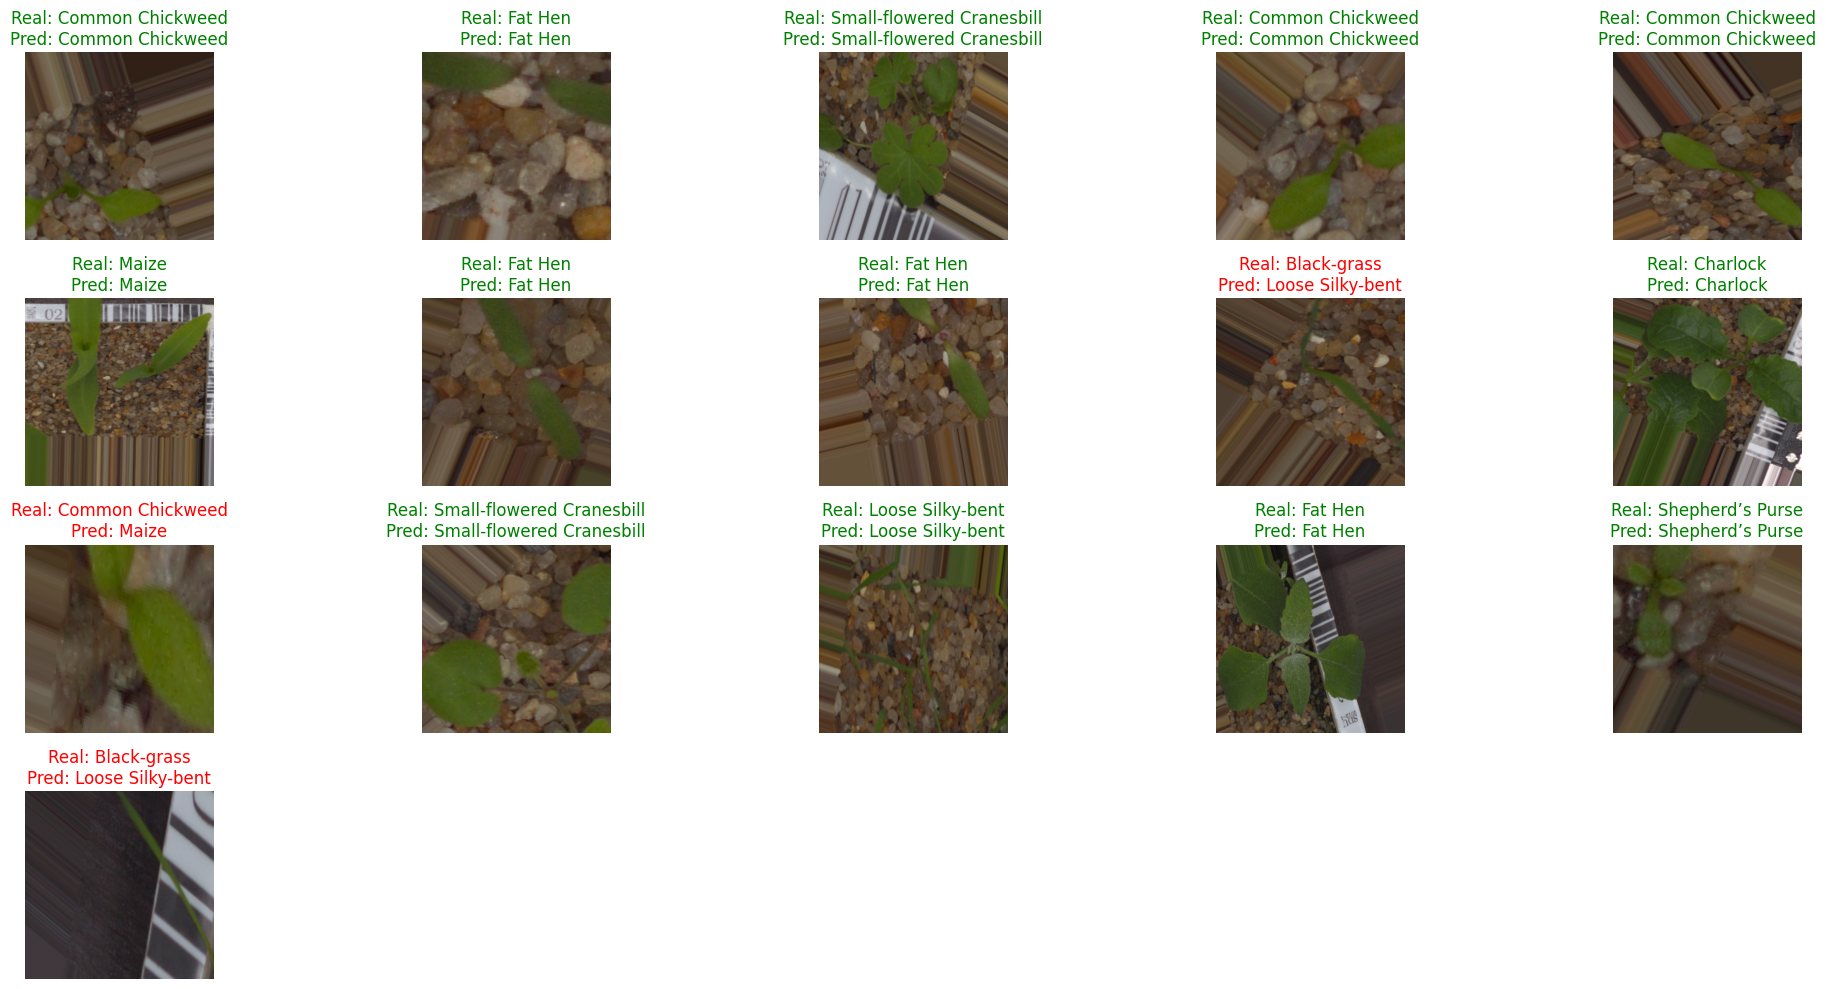

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Carregar um lote de 20 imagens do validation_generator
images, true_labels = next(validation_generator)  # Gera um lote do generator
predicted_probabilities = model.predict(images)  # Predições
predicted_labels = np.argmax(predicted_probabilities, axis=1)  # Classes preditas

# Obter nomes das classes (rótulos) do generator
class_names = list(validation_generator.class_indices.keys())

# Determine the number of images in the batch
num_images = images.shape[0]  # Get the size of the first dimension

# Plotar as imagens com rótulos reais e preditos
plt.figure(figsize=(20, 10))
# Iterate up to the number of images available
for i in range(num_images):
    plt.subplot(4, 5, i + 1)
    # Normalize image data to the range [0, 1]
    image = images[i] / 255.0  # Assuming your images are in the range [0, 255]
    plt.imshow(image)
    # Convert true_labels to integer labels before indexing into class_names
    true_class = class_names[np.argmax(true_labels[i])] # Assuming true_labels is one-hot encoded
    predicted_class = class_names[predicted_labels[i]]
    plt.title(f"Real: {true_class}\nPred: {predicted_class}", color="green" if true_class == predicted_class else "red")
    plt.axis("off")
plt.tight_layout()
plt.show()

69/69 ━━━━━━━━━━━━━━━━━━━━ 29s 418ms/step


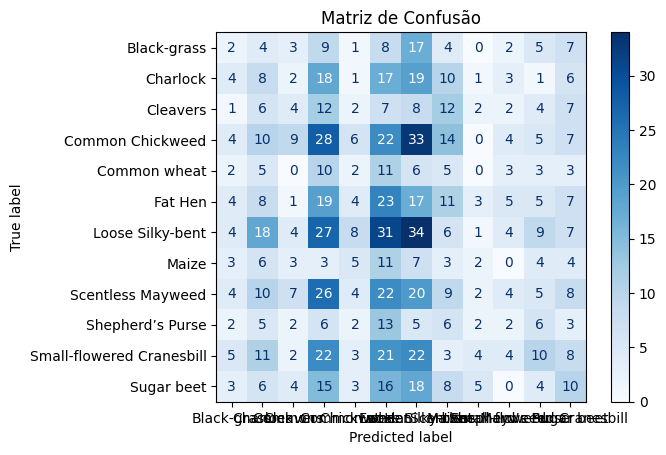

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Exemplo de rótulos reais e predições (substitua pelos seus dados)
true_labels = validation_generator.classes  # Rótulos reais
predicted_probabilities = model.predict(validation_generator)  # Predições do modelo
predicted_labels = np.argmax(predicted_probabilities, axis=1)  # Classes preditas

# Gerar a matriz de confusão
cm = confusion_matrix(true_labels, predicted_labels)

# Exibir a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=validation_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão")
plt.show()
